# - Digital Signal Processing

Tacademy의 '디지털신호처리 이해'를 보고 정리

In [1]:
!pip install torch
!pip install torchaudio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1. Digital Signal Processing

목적은 소리 signal을 어떠한 데이터 타입으로 표현하며, 소리와 관련된 task를 해결하는데 있음.

## Sound

소리는 일반적으로 진동으로 인한 공기의 압축으로 생성됨. 압축이 얼마나 됐느냐에 따라서 표현되는것이 Wave(파동). 파동은 진동하며 공간/매질을 전파해 나가는 현상임. 질량의 이동은 없지만 에너지/운동량의 운반은 존재

Wave에서 얻을수 있는 정보는 크게 3가지
- Phase(Degress of displacement) : 위상
- Amplitude : 진폭
- Frequency : 주파수

## Sampling

Contiuous 한 데이터를 잘게 쪼개서 discrete한 디지털 정보로 표현할 필요가 있음. 무한하게 쪼개서 저장할 수 없으니, 어떤 기준을 가지고 아날로그 정보를 쪼개서 대표값을 취하게 됨. 즉, Sampling을 한다는 말.

***Convert into a sequence of binary values via Sampling and Quantization***

## 1.1 Time domain

시간을 기준으로 아날로그 시그널을 쪼개게 되는것. Sampling을 통하여 컴퓨터는 소리 sequence를 binary value로 받아드리게됨.


### Sampling rate <- 설정값을 어떻게?

잘게 쪼갤수록 원본 데이터와 거의 가까워지기 때문에 좋지만 Data의 양이 증가하게 됨. 만약 너무 크게 쪼개게 된다면, 원본 데이터로 reconstruct하기 힘듬. 각각의 장단점이 존재


### Sampling theorem

샘플링 레이트가 최대 frequency의 2배 보다 커져야 한다는 것.<br/>
$f_s > 2f_m$ ($f_s$: sampling rate, $f_m$: maximum frequency)<br/>
- Nyqusit frequency = $f_s/2$, sampling rate의 절반

일반적으로 Sampling은 인간의 청각 영역에 맞게 형성
- Audio CD : 44.1 kHz(44100 sample/second)
- Speech communication : 8 kHz(8000 sample/second)

In [2]:
# Data preview
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchaudio

In [3]:
# tra
# train_dataset = torchaudio.datasets.LIBRISPEECH("./", url="train-clean-100", download=True)
test_dataset = torchaudio.datasets.LIBRISPEECH("./", url="test-clean", download=True)

  0%|          | 0.00/331M [00:00<?, ?B/s]

In [4]:
# data
print(type(test_dataset), len(test_dataset))
print(test_dataset[2])

print(test_dataset[2][4] / test_dataset[2][1]) # duration

<class 'torchaudio.datasets.librispeech.LIBRISPEECH'> 2620
(tensor([[ 0.0004,  0.0006,  0.0008,  ..., -0.0001, -0.0004, -0.0007]]), 16000, 'AFTER EARLY NIGHTFALL THE YELLOW LAMPS WOULD LIGHT UP HERE AND THERE THE SQUALID QUARTER OF THE BROTHELS', 1089, 134686, 2)
8.417875


2620개의 speech data<br/>
각각의 데이터는 다음과 같은 튜플로 구성되어있음.<br/>
(data(tensor 자료형), sampling rate, utterance, _, 전체길이, 인덱스)

In [5]:
test_dataset[1][0].shape # torch 자료형으로 0번 차원이 추가되어있음

torch.Size([1, 52400])

In [6]:
audio_data = test_dataset[1][0][0] # 0번 차원 제외시켜줌
sr = test_dataset[1][1] # sampling rate
print(audio_data, audio_data.shape)

tensor([ 0.0010,  0.0011,  0.0009,  ..., -0.0007, -0.0010, -0.0011]) torch.Size([52400])


In [7]:
len(audio_data) / sr # duration

3.275

In [8]:
test_dataset[1][2]

'STUFF IT INTO YOU HIS BELLY COUNSELLED HIM'

In [9]:
import IPython.display as ipd
ipd.Audio(audio_data, rate=sr)

In [10]:
# 16kHz -> 8kHz 2배 느려짐
ipd.Audio(audio_data, rate=8000)

In [11]:
# 16kHz -> 32kHz 2배 빨라짐
ipd.Audio(audio_data, rate=32000)

## Resampling

샘플링된 데이터를 더 높은 sampling rate 혹은 더 낮은 sampling rate로 다시 샘플링.<br/>
이때는 일반적으로 interpolation을 할때는 low-pass filter를 사용 (Windowed sinc function)

In [12]:
y_32k = librosa.resample(audio_data.numpy(), sr, 32000) # torch에서 바로 import해서tensor로 되어있어서 numpy의 array로 변경
ipd.Audio(y_32k, rate=32000)

In [13]:
y_8k = librosa.resample(audio_data.numpy(), sr, 8000)
ipd.Audio(y_8k, rate=8000)

In [14]:
print(audio_data.numpy()[:8])

print(y_8k[:8])
print(y_32k[:8])

print('16kHz:', len(audio_data.numpy()), '8kHz:', len(y_8k), '32kHz:', len(y_32k))

[0.0010376  0.00109863 0.00091553 0.00234985 0.0032959  0.00350952
 0.00204468 0.00088501]
[ 0.00066298  0.00136352  0.00319742  0.00233951 -0.00029481 -0.00242935
 -0.00051354  0.0018827 ]
[0.001049   0.00130799 0.00108487 0.00078758 0.00093091 0.00157119
 0.00233372 0.00291286]
16kHz: 52400 8kHz: 26200 32kHz: 104800


In [15]:
# resampling과정에서 sampling를 과하게 줄이면 복원이 잘되지않음
y_4k = librosa.resample(audio_data.numpy(), sr, 4000)
ipd.Audio(y_4k, rate=4000)

진폭을 수정했을때는 소리 크기에만 변화가 있을까?

In [16]:
y_np = audio_data.numpy()
y_am = y_np * 0.0000001
ipd.Audio(y_am, rate=sr)

변화가 없는거같음. 그래서 그런지 아래에서 scale 조정이나 값에 변화를 줬을때 음성이 그대로 들리는거같음.<br/>
자세한건 더 알아봐야될듯.

## Normalization & Quantization

시간의 기준이 아닌 실제 amplitude의 real valued를 기준으로 시그널의 값을 조절함. Amplitude를 이산적인 구간으로 나누고, signal 데이터의 Amplitude를 반올림.

이산적인 구간을 나눌때는 bit의 비트에 의해서 결정
- B bit의 Quantization : $-2^{B-1}$~$2^{B-1} - 1$
- Audio CD의 Quantization (16 bits) : $-2^{15}$~$2^{15} - 1$
- 위 값들은 보통 -1.0 ~ 1.0 영역으로 scaling 되기도 함

In [17]:
# Normalization
audio_np = audio_data.numpy()
normed_wav = audio_np / max(np.abs(audio_np)) # -1.0 ~ 1.0 사이값으로 변함
ipd.Audio(normed_wav, rate=sr)

In [18]:
# Quantization 하면 음질은 떨어지지만 light한 자료형이 됨
Bit = 8
max_value = 2 ** (Bit-1)

quantized_8_wav = normed_wav * max_value
quantized_8_wav = np.round(quantized_8_wav).astype(int)
quantized_8_wav = np.clip(quantized_8_wav, -max_value, max_value-1) # 최대최소값을 설정하고 그보다 위와 아래값을 최대최소값으로 변경
ipd.Audio(quantized_8_wav, rate=sr)

In [19]:
# norm-quanti 한번에
def norm_quanti(x, bit):
    # normalization
    x = x / max(np.abs(x))

    # quantization
    max_value = 2 ** (bit-1)

    q_x = x * max_value
    q_x = np.round(q_x).astype(int)
    q_x = np.clip(q_x, -max_value, max_value-1)

    return q_x

quantized_8_wav = norm_quanti(audio_np, 8)
ipd.Audio(quantized_8_wav, rate=sr)

print(max(quantized_8_wav), min(quantized_8_wav))

127 -97


## mu-law encoding

사람의 귀는 소리의 amplitude에 대해 log적으로 반응함. 즉, 작은 소리의 차이는 잘잡아내는데 반해 소리가 커질수록 그 차이를 잘 느끼지 못함. 이러한 특성을 wave값을 표현하는데 반영해서 작은값에는 높은 분별력(high resolution)을, 큰값끼리는 낮은 분별력(low resolution)을 갖도록 함.

In [20]:
def mu_law(x, mu=255):
    return np.sign(x) * np.log(1 + mu * np.abs(x)) / np.log(1 + mu)

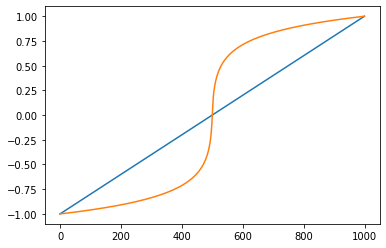

In [21]:
x = np.linspace(-1, 1, 1000)
x_mu = mu_law(x)

plt.figure(figsize=(6, 4))
plt.plot(x)
plt.plot(x_mu)
plt.show()

In [22]:
wav_mulaw = mu_law(normed_wav)
ipd.Audio(wav_mulaw, rate=sr)

# 2. Sound Representation

위에서 Sampling된 discrete한 데이터를 이제 우리는 표현이 가능. 그렇다면 어떤 요소를 기반으로 데이터를 표현해야될까?<br/>
첫번째는 시간의 흐름에 따라, 공기의 파동의 크기로 보는 Time-Domain Representation 방법.<br/>
두번째는 시간에 따라서 frequency의 변화를 보는 Time-Frequency Representation이 있음.

## 2.1 Time domain - Waveform

Waveform의 경우에는 오디오의 자연적인 표현. 시간이 x축으로 그리고 amplitude가 y축으로 표현이 됨.

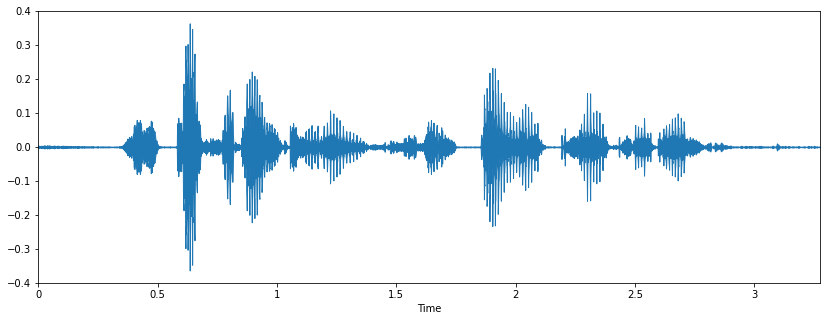

In [23]:
import librosa.display

audio_np = audio_data.numpy()

fig = plt.figure(figsize=(14, 5))
librosa.display.waveplot(audio_np, sr=sr)

## 정현파 (Sinusoid)

모든 신호는 주파수(frequency)와 크기(magnitude), 위상(phase)이 다른 정현파(sinusolida signal)의 조합으로 나타낼 수 있다.<br/> 푸리에 변환은 조합된 정현파의 합(하모니)신호에서 그 신호를 구성하는 정현파들을 각각 분리해내는 방법이다.<br/>

$x(t) = A cos(w_0t + 𝜙)$

In [24]:
A = 0.9
f = 340 # 계이름 '라'
phi = np.pi/2
fs = 22050
t = 1
# 여러개의 정현파를 합치면 소리의 신호. 반대로 소리에서 정현파를 분리할 수 있음.

In [25]:
def Sinusoid(A, f, phi, fs, t):
    t = np.arange(0, t, 1.0/fs)
    x = A * np.cos(2*np.pi*f*t + phi)
    return x

In [26]:
sin = Sinusoid(A, f, phi, fs, t)
sin2 = Sinusoid(1.2, 294, phi, fs, t)

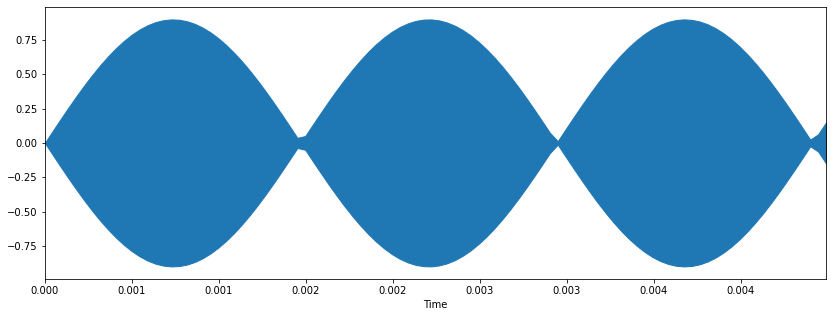

In [27]:
fig = plt.figure(figsize=(14, 5))
librosa.display.waveplot(sin[:100], sr=fs)

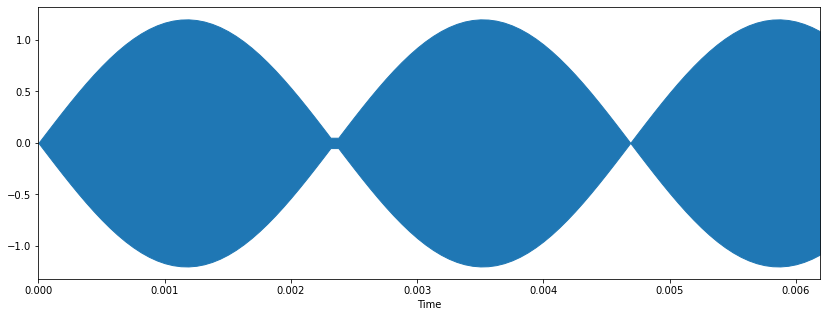

In [28]:
fig = plt.figure(figsize=(14, 5))
librosa.display.waveplot(sin2[:100], sr=sr)

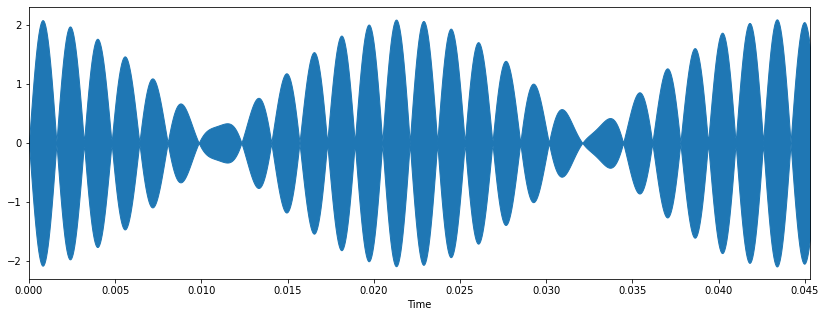

In [29]:
complexwave = sin + sin2

fig = plt.figure(figsize=(14, 5))
librosa.display.waveplot(complexwave[:1000], sr = fs)

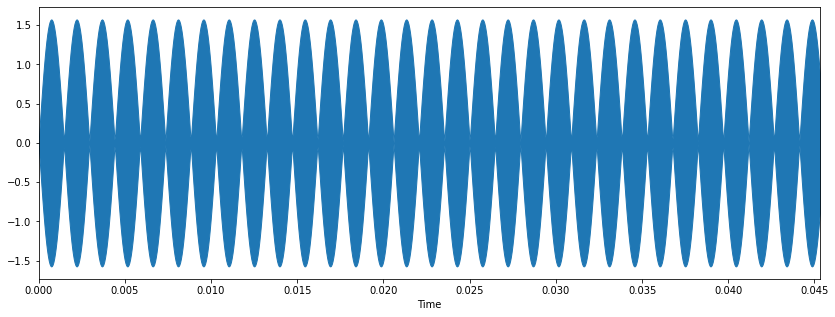

In [30]:
complexwave2 = sin + sin/2 + sin/4

fig = plt.figure(figsize=(14, 5))
librosa.display.waveplot(complexwave2[:1000], sr = fs)

In [31]:
ipd.Audio(complexwave2, rate=fs)

In [32]:
def generate_sinusoid_scale(pitches=[69], duration=0.5, Fs=22050, amplitude_max = 0.5):
    N = int(duration * Fs)
    t = np.arange(N) / Fs
    x = []
    for p in pitches:
        omega = 2 ** ((p - 69) / 12) * 440
        x = np.append(x, np.sin(2 * np.pi * omega * t))
    x = amplitude_max * x / np.max(x)
    return x

duration = 1
Fs = 22050

pitches = [36, 48, 60, 72, 84, 96]
x = generate_sinusoid_scale(pitches=pitches, duration=duration, Fs=Fs)

print('Pitch class C = {..., C1, C2, C3, C4, C5, C6, ...}', flush=True)
ipd.display(ipd.Audio(data=x, rate=Fs))

Pitch class C = {..., C1, C2, C3, C4, C5, C6, ...}


### 푸리에 변환 (Fourier transform)

푸리에 변환(Fourier transform)을 직관적으로 설명하면 푸리에 변환은 임의의 입력 신호를 다양한 주파수를 갖는 주기함수(복수 지수함수)들의 합으로 분해하여 표현하는 것이다. 그리고 각 주기함수들의 진폭을 구하는 과정을 푸리에 변환이라고 함.
- 주기(period) : 파동이 한번 진동하는데 걸리는 시간, 또는 그 길이, 일반적으로 sin 함수의 주기는 $2π/w$
- 주파수(frequency) : 1초동안의 진동 횟수

푸리에 변환의 식은 다음과 같음.<br/>

$$
y(t) = \sum_{k=-\infty}^\infty A_k \, \exp \left( i\cdot 2\pi\frac{k}{T}t \right)
$$

이 식을 하나씩 해석해보자. k는 [$-\infty$, $\infty$]의 범위를 가지고 움직임. 이것은 주기함수들의 개수. 어떠한 신호가 다른 주기함수들의 합으로 표현되는데, 그 주기함수는 무한대의 범위에 있음.

$A_k$는 그 사인함수의 진폭. 이 식은 시간에 대한 입력신호 $y_t$가 $\exp \left(i\cdot 2π\frac{k}{T}t \right)$와 진폭($A_k$)의 선형결합으로 표현됨을 말하고 있음.

위 그림을 본다면 조금 더 명확히 알 수 있음. 붉은색 라인이 입력신호 $y_t$. 일반적으로 우리가 다루게 되는 데이터인 음악이나 목소리 같은 데이터 역시 complex tone임. 여러개의 주파수영역이 합쳐진 것. 이러한 여러개의 주파수 영역을 분리하자 가 주요한 아이디어. 파란색 주기함수들을 보면 여러개의 주기함수들을 찾을 수 있음. 그 주기함수들은 고유의 주파수(frequency)와 강도(amplitude)를 가지고 있고 그것이 파란색의 라인들로 표현되어있음.

진폭에 대한 수식은 다음과 같음.
$$
A_k = \frac{1}{T} \int_{-\frac{T}{2}}^\frac{T}{2} f(t) \, \exp \left(-i \cdot 2π\frac{k}{T} t \right) \, dt
$$

위에선 주기함수의 합으로 표현된다고 했는데 우리가 보고 있는것은 $\exp \left(i\cdot 2π\frac{k}{T}t \right)$ 지수함수의 형태임.

지수함수와 주기함수 사이의 연관관계는 오일러 공식으로부터 알수있음.
$$
e^{i\theta} = \cos{\theta} + i\sin{\theta}
$$
이 식을 위 식처럼 표현한다면 다음과 같음.
$$
\exp \left(i\cdot 2π\frac{k}{T}t \right) = \cos\left({2π\frac{k}{T}t}\right) + i\sin\left({2π\frac{k}{T}t}\right)
$$

여기서 $\cos\left({2π\frac{k}{T}t}\right)$, $i\sin\left({2π\frac{k}{T}t}\right)$ 함수는 주기와 주파수를 가지는 주기함수

즉, 푸리에 변환은 입력 signal이 어떤것인지 상관없이 sin, cos과 같은 주기함수들의 합으로 항상 분해 가능하다는 것.


### Fourier Transform의 Orthogonal

$$
y(t) = \sum_{k=-\infty}^{\infty}A_k \, \exp\left(i \cdot 2π \frac{k}{T} t \right)
$$

어떠한 주기함수를 우리는 cos과 sin함수로 표현하게 되었음. 여기서 한가지 재밌는 점은, 이 함수들이 직교하는 함수(orthogonal)라는 점이다.
$$
\{\exp\left(i \cdot 2π \frac{k}{T} t \right)\} = orthogonal
$$

벡터의 직교는 해당 벡터를 통해 평면의 모든 좌표를 표현할 수 있었다. 함수의 내적은 적분으로 표현할 수 있는데,만약 구간 [a,b]에서 직교하는 함수는 구간 [a,b]의 모든 함수를 표현할 수 있음. 위 케이스에서는 cos, sin 함수가 사실상 우리 입력신호에 대해서 기저가 되어주는 함수라고 생각할 수 있음.

### DFT (Discrete Fourier Transform)

한가지 의문점은 우리가 sampling으로 들어온 데이터는 바로 시간 간격에 따른 소리의 amplitude의 discrete한 데이터이기 때문이다. 그렇다면 위 푸리에 변환 식을 Discrete한 영역으로 생각해보자.

만약에 우리가 수집한 데이터 $y_n$에서, 이산 시계열 데이터가 주기 N으로 반복한다고 할때, DFT는 주파수와 진폭이 다른 N개의 사인 함수의 합으로 표현이가능함.

$$
y_n = \frac{1}{N}\sum_{k=0}^{N-1}Y_k\cdot \exp\left(i\cdot 2π \frac{k}{N} n \right)
$$

위 식을 보면 k의 range가 0부터 $N-1$로 변화했음을 알 수 있다. 이때 Spectrum $Y_k$를 원래의 시계열 데이터에 대한 푸리에 변환값이라고함.

$$
Y_k = \sum_{n=0}^{N-1}y_n\cdot \exp\left(i\cdot 2π \frac{k}{N} n \right)
$$

- $y_n$ : input signal
- $n$ : Discrete time index
- $k$ : discrete frequency index
- $Y_k$ : k번째 frequency에 대한 Spectrum의 값

In [33]:
def DFT(x):
    N = len(x)
    X = np.array([])
    nv = np.arange(N)

    for k in range(N):
        s = np.exp(1j*2*np.pi*k/N*nv)
        X = np.append(X, sum(x*np.conjugate(s)))
    return X

### STFT (Short-Time Fourier Transform)

FFT는 시간의 흐름에 따라 신호의 주파수가 변했을때, 어느 시간대에 주파수가 변하는지 모르게 됨. 이러한 한계를 극복하기 위해서, STFT는 시간의 길이를 나눠서 푸리에 변환을 함. 즉 FFT를 했을때는 Time domain에 대한 정보가 날아가게 되는 것.

주파수의 특성이 시간에 따라 달라지는 사운드를 분석하는 방법. 일반적으로 우리가 사용하는 signal 데이터에 적합하다. 시계열 데이터를 일정한 시간 구간 (window size)로 나누고, 각 구간에 대해서 스펙트럼을 구하는 데이터이다. 이는 Time-frequency 2차원 데이터로 표현이 됨.

$$
X(l,k) = \sum_{n=0}^{N-1} w(n)x(n+lH)\exp^{-\frac{2\pi kn}{N}}
$$

- $N$ : FFT size
    - Window를 얼마나 많은 주파수 밴드로 나누는가

- Duration
    - 샘플링 레이트를 window로 나눈 값
    - $T = window/SR$
    - T(Window) = 5T(Signal), duration은 신호주기보다 5배 이상 길게 잡아야됨
    - 440Hz 신호의 windwo size는 5*(1/440)이 됨

- $w(n)$ : Window function
    - 일반적으로 Hann windwo가 쓰임

- $n$ : Window size
    - Window 함수에 들어가는 Sample의 양
    - 작을수록 Low-frequency resolution을 가지게 되고, high-time resolution을 가짐
    - 길수록 High-frequency, low time resolution을 가짐.

- $H$ : Hop size
    - 윈도우가 겹치는 사이즈. 일반적으로는 1/4정도를 겹치게 함.

STFT의 결과는 즉 시간의 흐름(Window)에 따른 Frequency 영역별 Amplitude를 반환함.

In [34]:
audio_data = test_dataset[1][0][0]
sr = test_dataset[1][1]

print(audio_data, audio_data.shape)
audio_np = audio_data.numpy()

tensor([ 0.0010,  0.0011,  0.0009,  ..., -0.0007, -0.0010, -0.0011]) torch.Size([52400])


In [35]:
# STFT
S = librosa.core.stft(audio_np, n_fft=1024, hop_length=512, win_length=1024)
S.shape, len(S[0]), S[0][0]
# input shape가 파라미터에 따라 변하므로 중요함!

((513, 103), 103, (0.044214446+0j))

In [36]:
S

array([[ 0.04421445+0.0000000e+00j, -0.05884637+0.0000000e+00j,
        -0.02625498+0.0000000e+00j, ...,  0.04703658+0.0000000e+00j,
        -0.10275772+0.0000000e+00j,  0.08220159+0.0000000e+00j],
       [-0.05259015+4.5265441e-18j,  0.03790738-7.8518270e-03j,
        -0.00889512-9.1458801e-03j, ..., -0.04557749-2.3772500e-01j,
         0.13888891+3.1923160e-01j,  0.03552139-1.2787430e-01j],
       [ 0.12074988-9.4017379e-19j, -0.00690025-3.0232264e-02j,
         0.02921003+1.3654881e-02j, ..., -0.01928553+1.3721973e-01j,
        -0.1489643 -2.5934309e-01j, -0.21872273+7.9142088e-03j],
       ...,
       [-0.00197292+5.1685624e-18j, -0.00134465+2.0302692e-03j,
         0.00111155-1.3944925e-03j, ...,  0.00076722-1.4168157e-03j,
         0.00215575+1.2777701e-03j, -0.00033017-6.4555433e-04j],
       [-0.00401945-4.5265441e-18j, -0.001215  -2.1861666e-03j,
        -0.00376799+3.1128232e-03j, ..., -0.00342117+3.1496247e-03j,
        -0.00530687-2.5308989e-03j, -0.00067652+2.0682425e-03j]

In [37]:
# 복소항인 Phase에 대한 정보를 날림.
D = np.abs(S) ** 2
D.shape

(513, 103)

In [38]:
D

array([[1.9549173e-03, 3.4628955e-03, 6.8932399e-04, ..., 2.2124404e-03,
        1.0559149e-02, 6.7571020e-03],
       [2.7657242e-03, 1.4986208e-03, 1.6277027e-04, ..., 5.8590487e-02,
        1.2119895e-01, 1.7613605e-02],
       [1.4580535e-02, 9.6160325e-04, 1.0396814e-03, ..., 1.9201186e-02,
        8.9449197e-02, 4.7902271e-02],
       ...,
       [3.8923986e-06, 5.9300896e-06, 3.1801526e-06, ..., 2.5959896e-06,
        6.2799368e-06, 5.2575194e-07],
       [1.6155989e-05, 6.2555437e-06, 2.3887440e-05, ..., 2.1624561e-05,
        3.4568307e-05, 4.7353024e-06],
       [5.0417493e-05, 3.0068535e-05, 4.4681386e-05, ..., 3.8015805e-05,
        5.6579658e-05, 8.6019327e-06]], dtype=float32)

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:1545: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  "power_to_db was called on complex input so phase "


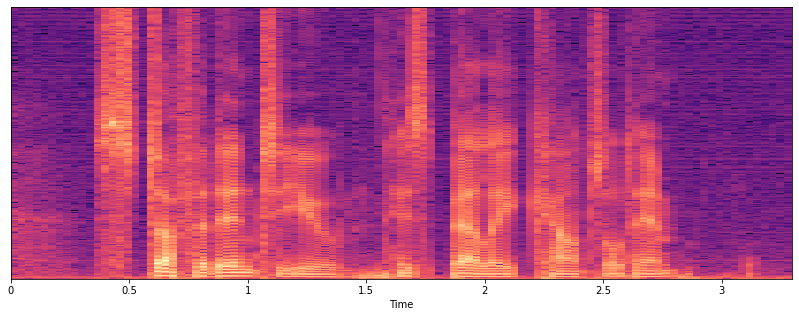

In [39]:
S = librosa.core.stft(audio_np, n_fft=1024, hop_length=512, win_length=1024)
D = np.abs(S)**2
log_S = librosa.power_to_db(S, ref=np.max) # 소리의 단위를 db로 바꿈 db은 측정값을 log 스케일로 보는것

plt.figure(figsize=(14, 5))
librosa.display.specshow(log_S, sr=16000, x_axis='time')

### Window function?

위에서 Window function과 Window size라는 이야기가 나오고 있음. Window function과 Size를 쓰는 이유는?

Window function의 주된 기능은 main-lobe의 width와 side-lobe의 레벨의 Trade-off를 제어해 준다는 장점이 있음. 그리고 깁스 현상을 막아주기도 함.<br/> 지금나온 main-lobe, side-lobe, 깁스현상은 무엇일까?

In [40]:
def frame_audio(audio, FFT_size=1024, hop_size=20, sample_rate=22050):
    audio = np.pad(audio, int(FFT_size/2), mode='reflect')
    frame_len = np.round(sample_rate*hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num, FFT_size))

    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len + FFT_size]
    return frames

audio_framed = frame_audio(audio_np)
print(f"Framed audio shape : {audio_framed.shape}")

Framed audio shape : (119, 1024)


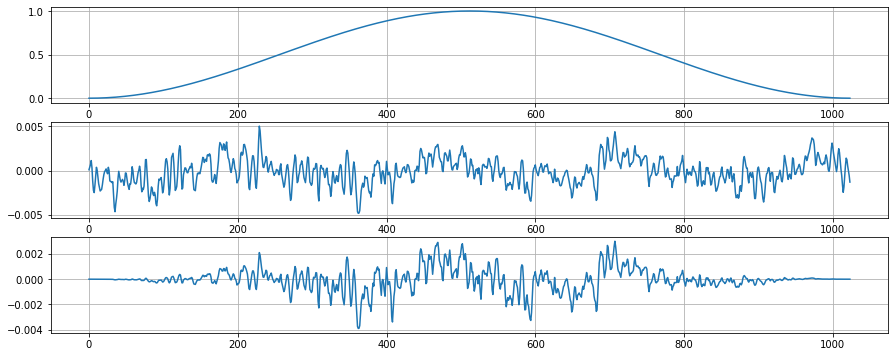

In [41]:
from scipy import signal

window = signal.get_window("hann", 1024, fftbins=True)
audio_win = audio_framed * window
ind = 2
plt.figure(figsize=(15, 6))
plt.subplot(3, 1, 1)
plt.plot(window)
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(audio_framed[ind])
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(audio_win[ind])
plt.grid(True)
plt.show()

plot을 보게 된다면 windowing을 적용하기전 plot은 끝부분이 다 다르지만, windowing을 지나고 나서 나오는 plot은 끝이 0으로 일치한다는 특성을 볼 수 있음.

### Window size?

윈도우 사이즈는 일반적으로 time과 frequency의 resolutions을 제어해줌.
- Short-window : 낮은 frequency resolution, 높은 time-resolution을 가지게됨.
- Long-window : 높은 frequency resolution을 가지며, 낮은 time-resolution을 가지게 됨.

### Spectrogram

Spectrogram을 추출하는 방법을 고민해보자. 일반적으로 프로세스는 입력신호에 대해서 window function을 통과하여 window size만큼 sampling된 data를 받아서 Discrete Fourier Transform을 거치게 된다. DFT를 거친 신호들은 Frequency와 Amplitude의 영역을 가지는 Spectrum이 됨.
이후 이를 90도로 회전시켜서, time domain으로 stack하게 됨.

Spectrogram은 Frequency Scale에 대해서 Scaling이 이루어짐. 주파수 영역에 Scaling을 하는 이유는, 인간의 주파수를 인식하는 방식과 연관이 있음.

일반적으로 사람은, 인접한 주파수를 크게 구별하지 못함. 그 이우는 우리의 인지기관이 categorical한 구분을 하기때문이다. 때문에 우리는 주파수들의 Bin의 그룹을 만들고 이들을 합하는 방식으로, 주파수 영역에서 얼마만큼의 에너지가 있는지를 찾으볼 것이다. 일반적으로는 인간이 낮은 주파수에 더 풍부한 정보를 사용하기 때문에, 주파수가 올라갈수록 필터의 폭이 높아지면서 고주파는 거의 고려를 안하게됨.

따라서 아래 frequency scale은 어떤방식을 통해 저주파수대 영역을 고려할 것인가에 대한 고민이 남아 있다.

### Linear frequency scale

일반적으로 single tone(순음)들의 배음 구조를 파악하기 좋다. 하지만 분포가 저주파수 영역에 기울어져(skewed) 있음.

### Mel Scale

멜 스펙트럼은 주파수 단위를 다음 공식에 따라 멜 단위로 바꾼 것을 의미함.
$$
m = 2595\log_{10}(1 + \frac{f}{700})
$$

일반적으로는 mel-scaled bin을 FFT size보다 조금 더 작게 만든다.

In [42]:
# STFT
S = librosa.core.stft(audio_np, n_fft=1024, hop_length=512, win_length=1024)
# phase에 대한 정보를 날린다.
D = np.abs(S) ** 2

In [43]:
# mel spectrogram (512 --> 40)
mel_basis = librosa.filters.mel(sr, 1024, n_mels=40)

In [44]:
mel_S = np.dot(mel_basis, D)
mel_S.shape

(40, 103)

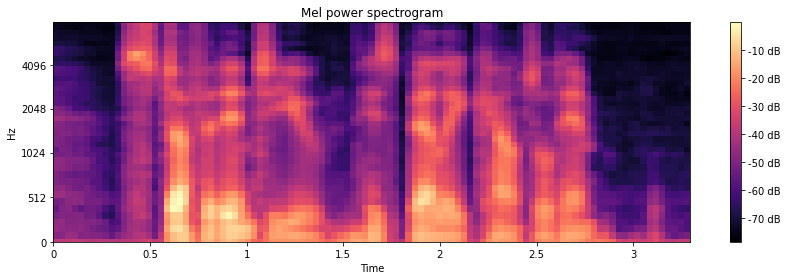

In [45]:
S = librosa.feature.melspectrogram(audio_np, sr=sr, n_mels = 40)
log_S = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

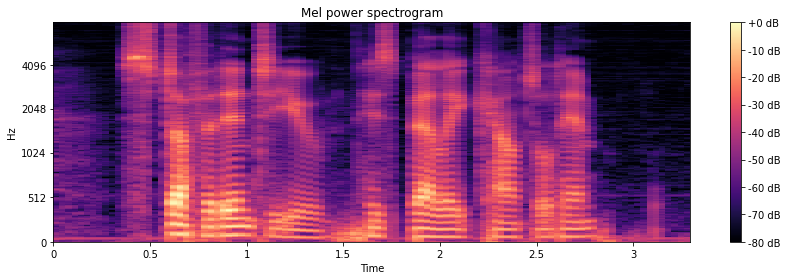

In [46]:
# mel size up
S = librosa.feature.melspectrogram(audio_np, sr=sr, n_mels = 256)
log_S = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

### Bark scale

귀가 인식하는 주파수의 영역은 대략 20Hz ~ 2000Hz로 가정한다. 하지만 주파수에 대한 사람의 인식은 비선형적임. 귀와 뇌의 가청대역을 24개의 대역으로 나눈것을 Bark라고 한다. Bark scale은 500Hz 이하에서는 100Hz의 대역폭을 가지며, 500Hz 이상에서는 각 개역의 중심주파수의 대략 20%에 해당하는 대역폭을 가지게 됨.

`20, 100, 200, 300, 400, 510, 630, 770, 920, 1080, 1270, 1480, 1720, 2000, 2320, 2700, 3150, 3700, 4400, 5300, 6400, 7700, 9500, 12000, 15500 ( Hz )`

### Log compression

$
10 * \log_{10}(\frac{S}{ref})
$
의 단위로 신호를 스케일링 함.<br/> 이는 spectrogram을 데시벨 유닛으로 전환해준다.

In [47]:
# log compression
log_mel_S = librosa.power_to_db(mel_S)
log_mel_S.shape

(40, 103)

### Discrete cosine transform (DCT)

DCT는 n개의 데이터를 n개의 코사인 함수의 합으로 표현하여 데이터의 양을 줄이는 방식이다.
- 저주파수에 에너지가 집중되고 고주파수 영역에 에너지가 감소함.

Filter Bank는 모두 Overlapping 되어 있기 때문에 Filter Bank 에너지들 사이에 상관관계가 존재하기 때문이다. DCT는 에너지들 사이에 이러한 상관관계를 분리 해주는 역할을 해줌.

하지만 여기서 26개 DCT Coefficient들 중 12만 남겨야 하는데, 그 이유는 DCT Coefficient가 많으면, Filter Bank 에너지의 빠른 변화를 나타내게 되고, 이것은 음성인식의 성능을 낮추게 되기 때문이다.

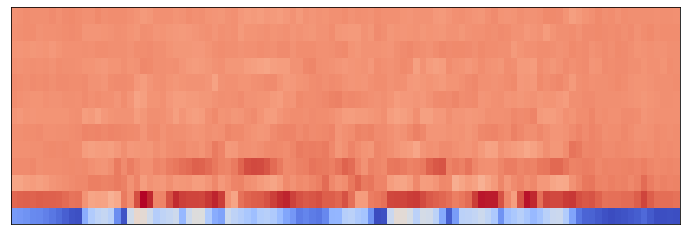

In [48]:
# mfcc (DCT)
mfcc = librosa.feature.mfcc(S=log_mel_S, n_mfcc=13)
mfcc = mfcc.astype(np.float32)   # to save the memory (64 to 32 bits)
plt.figure(figsize=(12, 4))
librosa.display.specshow(mfcc)

(13, 103)


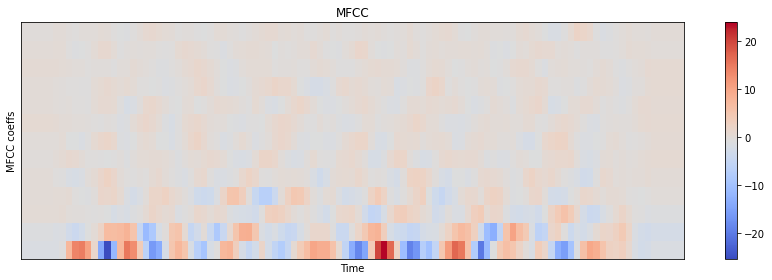

In [49]:
delta2_mfcc = librosa.feature.delta(mfcc, order=2)
print(delta2_mfcc.shape)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

# 3. Sound Augmentation

In [50]:
# 비교 위한 함수
def waveform_aug(waveform, waveform_c, sr):
    fig = plt.figure(figsize=(16, 8))
    plt.subplot(2, 1, 1)
    librosa.display.waveplot(waveform, sr=sr)
    plt.title('original')
    
    plt.subplot(2, 1, 2)
    librosa.display.waveplot(waveform_c, sr=sr)
    plt.title('change')
    plt.tight_layout()
    plt.show()

In [51]:
# 음높이 조정
def change_pitch(data, sr):
    y_pitch = data.copy()
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change = pitch_pm * 2 * (np.random.uniform())
    y_pitch = librosa.effects.pitch_shift(y_pitch.astype('float64'), sr, n_steps=pitch_change,
                                          bins_per_octave=bins_per_octave)
    return y_pitch

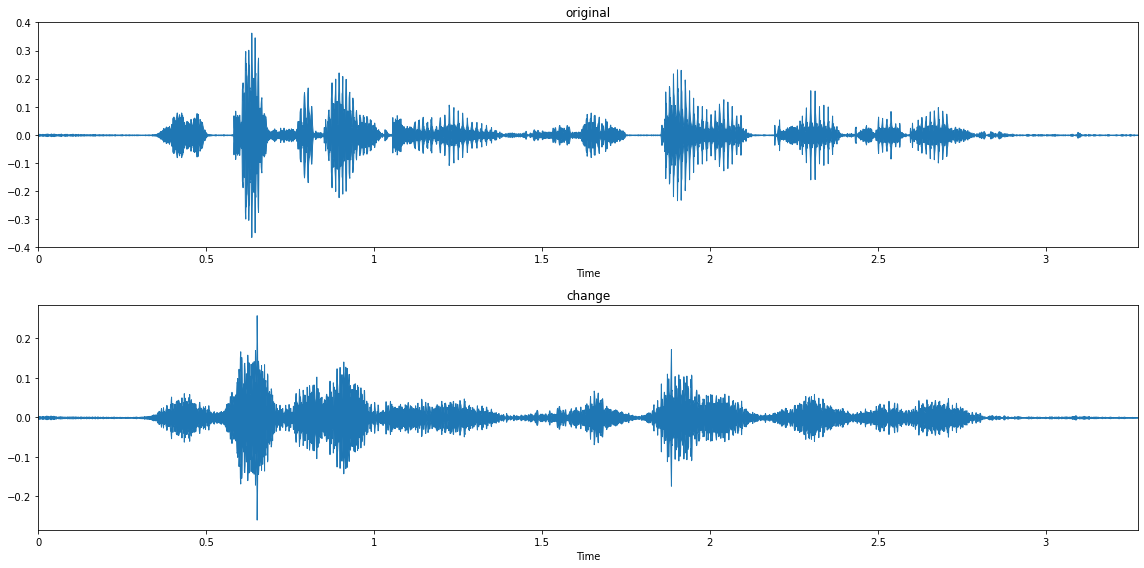

In [52]:
pit = change_pitch(audio_np, sr)

waveform_aug(audio_np, pit, sr)

In [53]:
ipd.Audio(audio_np, rate=sr)

In [54]:
ipd.Audio(pit, rate=sr)


이외에도 많은 augmentation이 있음.<br/>
그중에서도 성능 측면에서 좋은것은 Mel spectrogram의 일부분을 masking하는방식

# 4. DataLoader 만들어보기

In [59]:
# augmentation
import torch.nn as nn

train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
    torchaudio.transforms.TimeMasking(time_mask_param=35)
)

valid_audio_transforms = torchaudio.transforms.MelSpectrogram()

In [60]:
from scipy.signal.spectral import spectrogram
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader

class Dataset(Dataset):
    def __init__(self, x):
        self.x = x

    def __getitem__(self, index):
        return self.x[index]

    def __len__(self):
        return self.x.shape[0]

def load_dataset(data, data_type="train"):
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []

    for (waveform, _, _, _, _, _) in data:
        if data_type == 'train':
            spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        else:
            spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        spectrograms.append(spec)

    return spectrograms

def get_dataloader(data):
    x_train = load_dataset(data, "train")
    x_valid = load_dataset(data, "valid")

    mean = np.mean(x_train)
    std = np.std(x_train)
    x_train = (x_train - mean)/std
    x_valid = (x_valid - mean)/std

    train_set = Dataset(x_train)
    valid_set = Dataset(x_valid)

    train_loader = DataLoader(train_set, batch_size=4, shuffle=True, drop_last=False)
    valid_loader = DataLoader(valid_set, batch_size=4, shuffle=False, drop_last=False)

    return train_loader, valid_loader

In [ ]:
train_loader, valid_loader = get_dataloader(test_dataset)